<h3>More Practice with Classification</h3>

We continue the practice with the credit approval data. Remember last time, we built a sklearn pipeline that
1. Train/Test split with random split
2. Imputation
3. Create new features
4. Standardization
5. One Hot Encoder

Now, we apply different classification models on this data and compare their performances

In [49]:
import pandas as pd

crx = pd.read_csv('crx.data', header=None)

crx.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


We will convert '+' and '-' to 1 and 0 for better uses with sklearn

In [52]:
Y = np.zeros(crx.shape[0])           #create a vector of zeros with size = the data
Y[crx[15]=='+'] = 1                  #when the actual target is +, Y is assigned 1
crx[15] = Y                          #assign the new labels back to the data 

<h4>Train/Test Split </h4>

Recall, the target in this data is column 15, we will use stratified split based on column 15

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(crx, crx[15]):
    strat_train_set = crx.loc[train_index]
    strat_test_set = crx.loc[test_index]
    
trainX = strat_train_set.loc[:,:14]
trainY = strat_train_set.loc[:,15]
trainX.shape, trainY.shape

((517, 15), (517,))

<h4>Preprocessing</h4>

It is beneficial for some models to transform skewed columns using log function. This is not always necessary, but I want to demonstrate the use of FunctionTransformer, so let create a log versions of all numeric columns

In [37]:
import numpy as np

#get a list of numeric columns
num_cols = trainX.columns[trainX.dtypes==np.number]

#create a transform function for FunctionTransformer
def log_transform(X):                             #input of the function is any dataset X
    log_X = np.log(X + 0.1)                       #log of all columns of X, we add 0.1 to avoid log(0)
    return np.c_[X,log_X]                         #return X concatenated with log columns

Now we can build our numeric pipeline

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log transform', FunctionTransformer(log_transform, validate=False)),
    ('standardize', StandardScaler())
])

And the class pipeline. We will impute with missing category, then OneHotEncoder

In [56]:
from sklearn.preprocessing import OneHotEncoder

#get a list of class columns
cat_cols = trainX.columns[trainX.dtypes==object]

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encode', OneHotEncoder())
])

Then combine the two pipelines with ColumnTransformer

In [57]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

Finally, transform the data through the pipeline

In [58]:
trainX_prc = full_pipeline.fit_transform(trainX)

trainX_prc.shape

(517, 53)

In [59]:
#Similarly for testing data
testX = strat_test_set.loc[:,:14]
testY = strat_test_set.loc[:,15]

testX_prc = full_pipeline.transform(testX)  
testX_prc.shape

(173, 53)

<h3>Modeling</h3>

<h4>Logistic Regression</h4>

Accuracy:

In [60]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

from sklearn.model_selection import cross_val_score

accuracy_3cv = cross_val_score(logistic, trainX_prc, trainY, cv=3, scoring="accuracy")
print(accuracy_3cv)
print(accuracy_3cv.mean())

[0.87861272 0.86046512 0.83139535]
0.8568243939597616


Confusion Matrix:

In [61]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(logistic, trainX_prc, trainY, cv=3)

from sklearn.metrics import confusion_matrix

conf_matrx = confusion_matrix(trainY, y_train_pred)

print(conf_matrx)

[[248  39]
 [ 35 195]]


F1-Score:

In [62]:
from sklearn.metrics import f1_score
f1_score(trainY, y_train_pred)

0.8405172413793104

Precision-Recall Curve:

In [67]:
y_scores = cross_val_predict(logistic, trainX_prc, trainY, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(trainY, y_scores)

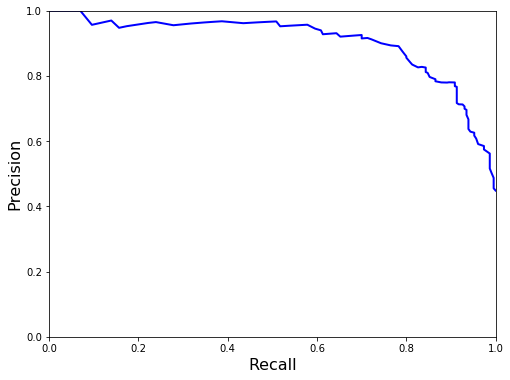

In [83]:
from matplotlib import pyplot as plt

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

ROC Curve:

In [70]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(trainY, y_scores)

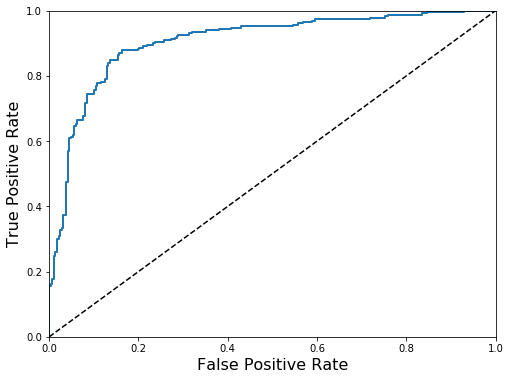

In [71]:
def plot_roc_curve(fpr, tpr, **options):
    plt.plot(fpr, tpr, linewidth=2, **options)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

Let also try <b>Random Forest</b>

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

accuracy_3cv = cross_val_score(rf, trainX_prc, trainY, cv=3, scoring="accuracy")
print(accuracy_3cv)
print(accuracy_3cv.mean())

[0.85549133 0.84302326 0.84883721]
0.8491172648653492


Confusion Matrix:

In [73]:
y_train_pred_rf = cross_val_predict(rf, trainX_prc, trainY, cv=3)

conf_matrx = confusion_matrix(trainY, y_train_pred_rf)

print(conf_matrx)

[[251  36]
 [ 38 192]]


F1-Score:

In [74]:
f1_score(trainY, y_train_pred_rf)

0.8384279475982531

Precision-Recall Curve:

In [81]:
y_probas_forest = cross_val_predict(rf, trainX_prc, trainY, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
precisions_rf, recalls_rf, thresholds = precision_recall_curve(trainY, y_scores_forest)

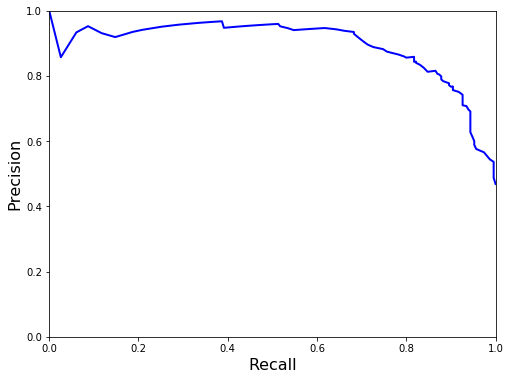

In [82]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_rf, recalls_rf)
plt.show()

We can compare this curve with the curve from Logistic Regression

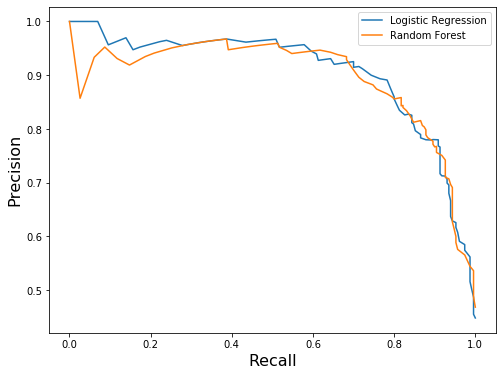

In [90]:
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions)                               #this plot() draws the pr curve for logistic regression
plt.plot(recalls_rf, precisions_rf)                         #this plot() draws the pr curve for random forest
plt.xlabel("Recall", fontsize=16)                           #if you have more models, just add more plot() with their
plt.ylabel("Precision", fontsize=16)                        #respective recall and precision vectors
plt.legend(['Logistic Regression', 'Random Forest'])        #this will create the legends. The legends must be in the same
plt.show()                                                  #order as the plot() calls for recalls and precisions

ROC Curve:

In [88]:
fpr_rf, tpr_rf, thresholds = roc_curve(trainY, y_scores_forest)

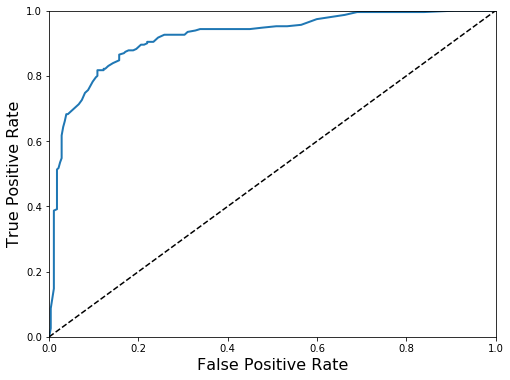

In [89]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rf, tpr_rf)

plt.show()

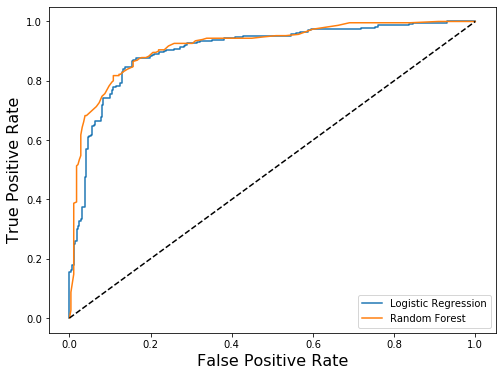

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)                                              #similar like pr curve, you can add more plot()
plt.plot(fpr_rf, tpr_rf)                                        #to compare more models
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(['Logistic Regression', 'Random Forest'])            #and add more legends here
plt.show()